## TD Control for Machine Replacement

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
def maintenance_cost(state):
    return state**2 + state

def cost_function(state, action, replacement_cost):
    if action == 0:
        return replacement_cost + maintenance_cost(0)
    else:
        return maintenance_cost(state)

In [33]:
# set total number of states and define a transition probability matrix of that size
num_states = 10
replacement_cost = 50
transition_probability_pre_change = np.zeros((2,num_states,num_states))
transition_probability_post_change = np.zeros((2,num_states,num_states))

In [34]:
C = [[cost_function(i, j, replacement_cost) for i in range(num_states)] for j in range(2)]
C = np.array(C)
C

array([[50, 50, 50, 50, 50, 50, 50, 50, 50, 50],
       [ 0,  2,  6, 12, 20, 30, 42, 56, 72, 90]])

In [35]:
def fill_transition_probability_matrix(transition_probability, p=0.5):
    for j in range(transition_probability.shape[1]-1):
        transition_probability[1][j][j] = p
        transition_probability[1][j][j+1] = 1-p
    for i in range(transition_probability.shape[1]):
        for j in range(transition_probability.shape[2]):
            transition_probability[0][i][j] = transition_probability[1][0][j]
    transition_probability[1, transition_probability.shape[1]-1, transition_probability.shape[1]-1] = 1


In [36]:
def policy_visualization(policy):
    plt.bar(range(num_states), policy)
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.show()

In [37]:
fill_transition_probability_matrix(transition_probability_pre_change, p=0.2)
fill_transition_probability_matrix(transition_probability_post_change, p=0.8)

In [38]:
def T(R, P, V, alpha=0.5):
    return R + alpha* (P @ V)


In [39]:
def evaluate_policy(f, C, P, V, delta=0.01, max_iter=10, transition_probability=None, N=num_states):
    R = np.array([C[int(f[i])][i] for i in range(N)])
    P = np.array([transition_probability[int(f[i]), i, :] for i in range(N) ])
    for i in range(max_iter):
        V_new = T(R, P, V)
        if(np.linalg.norm(V_new-V, np.inf) < delta):
            return V_new
        V = V_new
    return V

In [40]:
def improve_policy_greedy(C, P, V):
    q = [T(C[i], P[i], V) for i in range(2)]
    return np.argmin(q,axis=0), q

In [41]:
def modified_policy_iteration(C, P, max_evaluation_iter=100, initial_policy=np.random.random(num_states), max_iter=100, epsilon=0.01):
    V = np.zeros(num_states)
    V_history = []
    V_history.append(V.copy())
    policy = initial_policy
    q = np.zeros((2, num_states))
    for i in range(max_iter):
        V_new = evaluate_policy(policy, C, P, V, max_iter=max_evaluation_iter, transition_probability=P)
        policy, q = improve_policy_greedy(C, P, V_new)
        print(policy)
        V_history.append(V_new.copy())
        if np.linalg.norm(V_new-V, np.inf) < epsilon:
            return policy, V, V_history, q
        V = V_new
    return policy, V, V_history, q


[1 1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]


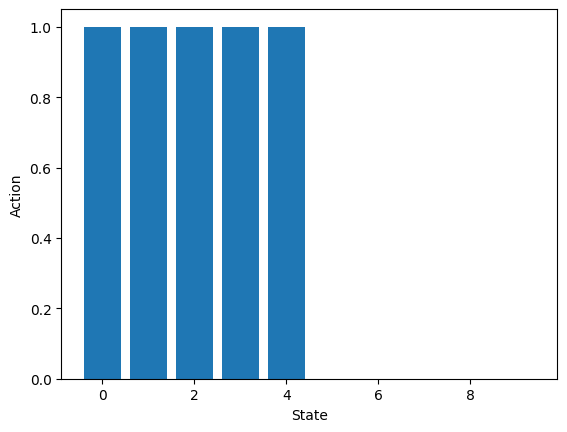

[ 5.30424363 11.93172553 21.84068272 34.13588236 46.8024375  55.30424363
 55.30424363 55.30424363 55.30424363 55.30424363]
[array([55.30208971, 55.30208971, 55.30208971, 55.30208971, 55.30208971,
       55.30208971, 55.30208971, 55.30208971, 55.30208971, 55.30208971]), array([  5.30208971,  11.92831305,  21.83766742,  34.1342328 ,
        46.80143995,  57.65155729,  69.65155729,  83.65155729,
        99.65155729, 117.65155729])]


In [42]:
policy_pre_change, V_pre_change, V_history_pre_change, q_final_pre_change = modified_policy_iteration(C, transition_probability_pre_change, max_iter=10)
policy_visualization(policy_pre_change)
print(V_pre_change)
print(q_final_pre_change)

[1 1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]


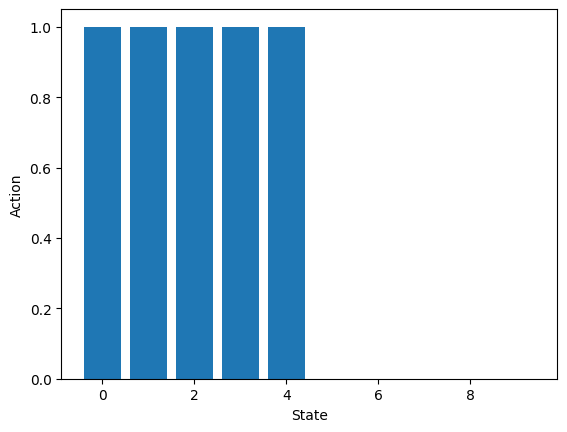

[ 0.95911812  5.75192149 14.50060025 26.97746288 41.82991065 50.95911812
 50.95911812 50.95911812 50.95911812 50.95911812]
[array([50.95861862, 50.95861862, 50.95861862, 50.95861862, 50.95861862,
       50.95861862, 50.95861862, 50.95861862, 50.95861862, 50.95861862]), array([  0.95861862,   5.75013009,  14.49659218,  26.97237809,
        41.82703437,  55.4794197 ,  67.4794197 ,  81.4794197 ,
        97.4794197 , 115.4794197 ])]


In [43]:
policy_post_change, V_post_change, V_history_post_change, q_final_post_change = modified_policy_iteration(C, transition_probability_post_change, max_iter=10)
policy_visualization(policy_post_change)
print(V_post_change)
print(q_final_post_change)

In [44]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

In [45]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

In [46]:
def qlearning(C, policy_class, alpha=0.1, gamma=0.5, max_steps=10000, max_restarts=10, num_pre_change_restarts=4, transition_probability_pre_change=None, transition_probability_post_change=None, should_decay_epsilon=True, initial_epsilon=1.0):
    Q = {}  # state-action value function
    policy = policy_class()

    policy.update(initial_epsilon)  # Initialize epsilon for epsilon-greedy policy

    # Track costs for convergence analysis
    Q_history_qlearning = []

    bellman_error = {}  # Track Bellman error for convergence analysis

    transition_probability = transition_probability_pre_change

    for i in tqdm(range(max_restarts)):
        # Initialize state randomly
        state = np.random.randint(0, num_states)
        if i >= num_pre_change_restarts:
            transition_probability = transition_probability_post_change
        for step in range(max_steps):
            # Choose initial action using current policy
            action = policy.policy(state, Q)

            # Initialize Q(s,a) if not seen before
            if state not in Q:
                Q[state] = np.zeros(2)

            # Take action and observe cost and next state
            cost = C[action, state]

            # Sample next state based on transition probabilities
            next_state = np.random.choice(
                num_states,
                p=transition_probability[action, state, :]
            )

            # Initialize Q(s',a') if not seen before
            if next_state not in Q:
                Q[next_state] = np.zeros(2)

            # Q-learning update: Q(s,a) = Q(s,a) + α[r + γmax_a'Q(s',a') - Q(s,a)]
            # Note: we use negative cost as reward since we want to minimize cost
            reward = cost
            td_target = reward + gamma * np.min(Q[next_state])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Track bellman error every 100 steps
            if step % 100 == 0:
                if state not in bellman_error:
                    bellman_error[state] = {}
                if action not in bellman_error[state]:
                    bellman_error[state][action] = []
                if i < num_pre_change_restarts:
                    optimal_q = q_final_pre_change[action][state]
                else:
                    optimal_q = q_final_post_change[action][state]
                bellman_error[state][action].append(np.abs(Q[state][action] - optimal_q))

            # Move to next state and action
            state = next_state
            action = policy.policy(state, Q)

            # store largest Q value for each state for convergence analysis
            Q_history_qlearning.append([np.min(Q[s]) if s in Q else 0 for s in range(num_states)])

            # Decay epsilon for epsilon-greedy policy
            if hasattr(policy, 'epsilon') and should_decay_epsilon:
                policy.update(policy.epsilon * 0.9)


    return Q, Q_history_qlearning, policy, bellman_error

In [47]:
# Run Q-learning with epsilon-greedy policy
print("Running Q-learning with Epsilon-Greedy Policy...")
Q_qlearning_final, Q_history_qlearning, policy_eg, bellman_error_qlearning = qlearning(
    C, EpsilonGreedyPolicy,
    alpha=0.1, gamma=0.5, max_steps=100, max_restarts=1000, transition_probability_pre_change=transition_probability_pre_change, transition_probability_post_change=transition_probability_post_change,
    num_pre_change_restarts=400
)
# Extract final policy
final_policy_qlearning = [policy_eg.final_policy(s, Q_qlearning_final) for s in range(num_states)]

Running Q-learning with Epsilon-Greedy Policy...


100%|██████████| 1000/1000 [00:08<00:00, 124.00it/s]


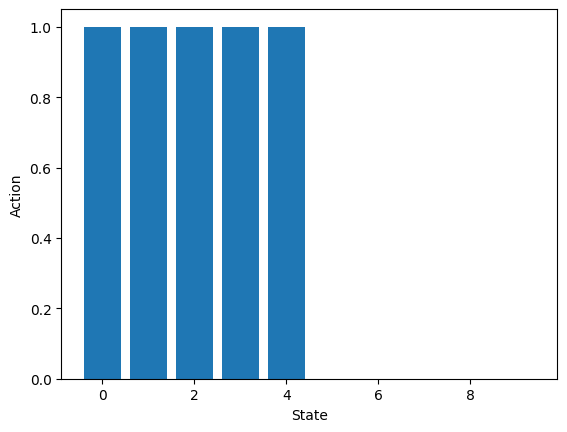

In [48]:
policy_visualization(final_policy_qlearning)

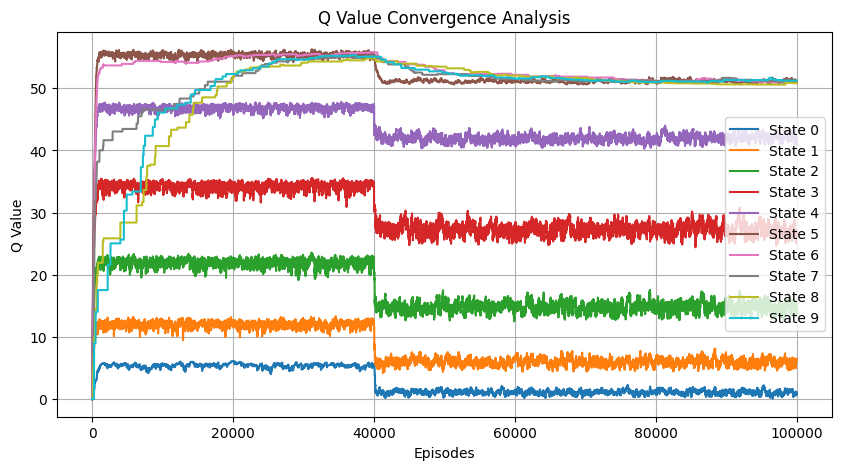

In [49]:
# Q value convergence analysis consider best Q value for each state
plt.figure(figsize=(10, 5))
# Plot the Q value for all states over episodes
for state in range(num_states):
    plt.plot(range(len(Q_history_qlearning)), [Q[state] for Q in Q_history_qlearning], label=f'State {state}')
plt.xlabel('Episodes')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

In [50]:
print("Final Q values for Q-learning:")
l = Q_qlearning_final.items()
l = sorted(l, key=lambda x: x[0])  # Sort by state
for state, actions in l:
    print(f"State {state}: {actions}")

Final Q values for Q-learning:
State 0: [9.75       1.01313871]
State 1: [14.2625      6.45283509]
State 2: [24.72649005 14.37575348]
State 3: [36.82371029 27.087198  ]
State 4: [48.55603795 41.74893379]
State 5: [50.87919706 56.38109061]
State 6: [50.94545149 57.04205197]
State 7: [51.06320142 57.59405473]
State 8: [50.81425898 57.97797274]
State 9: [51.23651695 60.58432237]


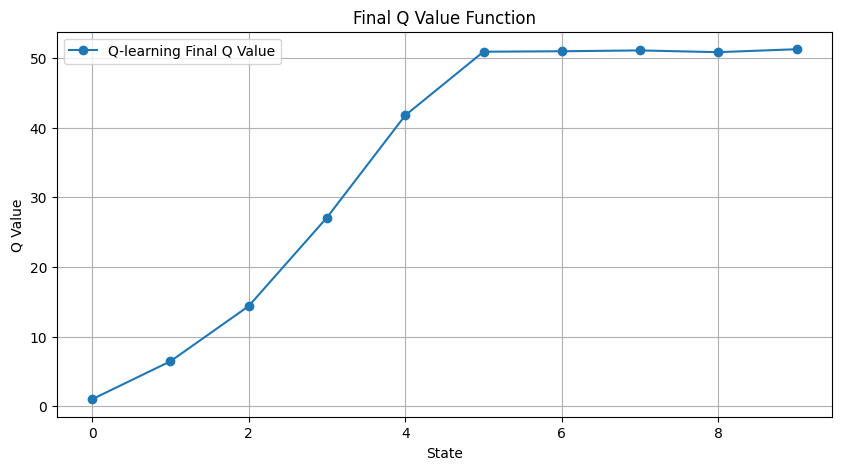

In [51]:
# plot final value function
plt.figure(figsize=(10, 5))
plt.plot(range(num_states), [np.min(Q_qlearning_final[s]) for s in range(num_states)], marker='o', label='Q-learning Final Q Value')
plt.xlabel('State')
plt.ylabel('Q Value')
plt.title('Final Q Value Function')
plt.legend()
plt.grid()
plt.show()

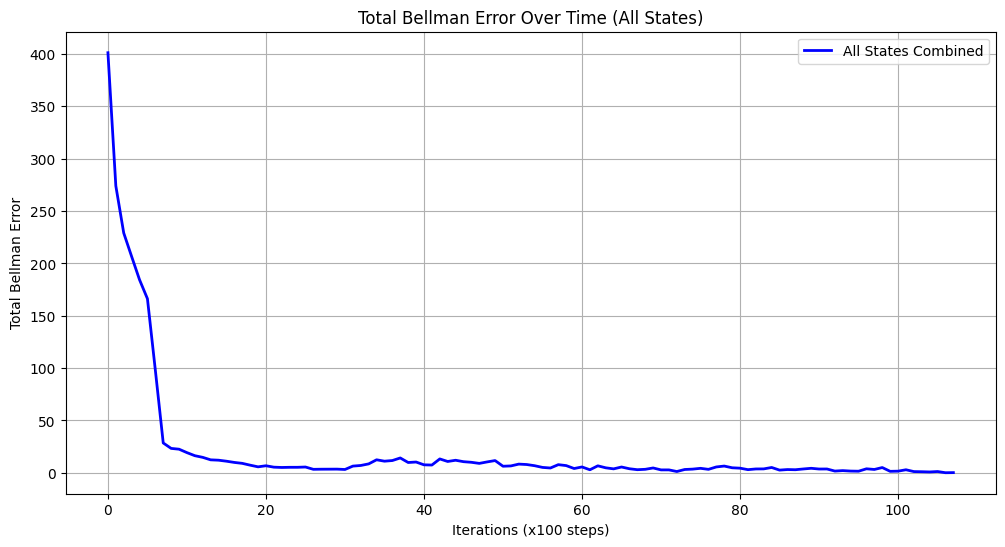

In [52]:
# Plot total Bellman error for all states (without cumulative sum over time)
plt.figure(figsize=(12, 6))

# Collect all Bellman errors with their timestamps
all_errors_by_time = {}

for state in bellman_error_qlearning:
    for action in bellman_error_qlearning[state]:
        for time_step, error in enumerate(bellman_error_qlearning[state][action]):
            if time_step not in all_errors_by_time:
                all_errors_by_time[time_step] = []
            all_errors_by_time[time_step].append(error)

# Calculate total errors at each time step (no cumulative sum)
time_steps = sorted(all_errors_by_time.keys())
total_errors_per_time = [sum(all_errors_by_time[t]) for t in time_steps]

plt.plot(time_steps, total_errors_per_time, 'b-', linewidth=2, label='All States Combined')
plt.xlabel("Iterations (x100 steps)")
plt.ylabel("Total Bellman Error")
plt.title("Total Bellman Error Over Time (All States)")
plt.legend()
plt.grid()
plt.show()

In [53]:
# Run Q-learning with epsilon-greedy policy
print("Running Q-learning with Epsilon-Greedy Policy...")
Q_qlearning_final, Q_history_qlearning, policy_eg, bellman_error_qlearning = qlearning(
    C, EpsilonGreedyPolicy,
    alpha=0.1, gamma=0.5, max_steps=100, max_restarts=1000, transition_probability_pre_change=transition_probability_pre_change, transition_probability_post_change=transition_probability_post_change, should_decay_epsilon=False, initial_epsilon=0.05, num_pre_change_restarts=400
)
# Extract final policy
final_policy_qlearning = [policy_eg.final_policy(s, Q_qlearning_final) for s in range(num_states)]

Running Q-learning with Epsilon-Greedy Policy...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 109.17it/s]


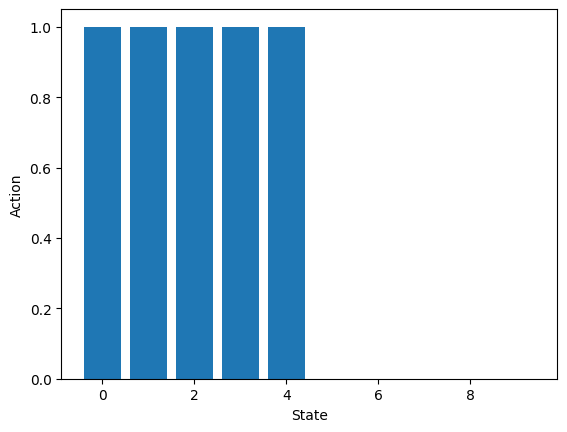

In [54]:
policy_visualization(final_policy_qlearning)

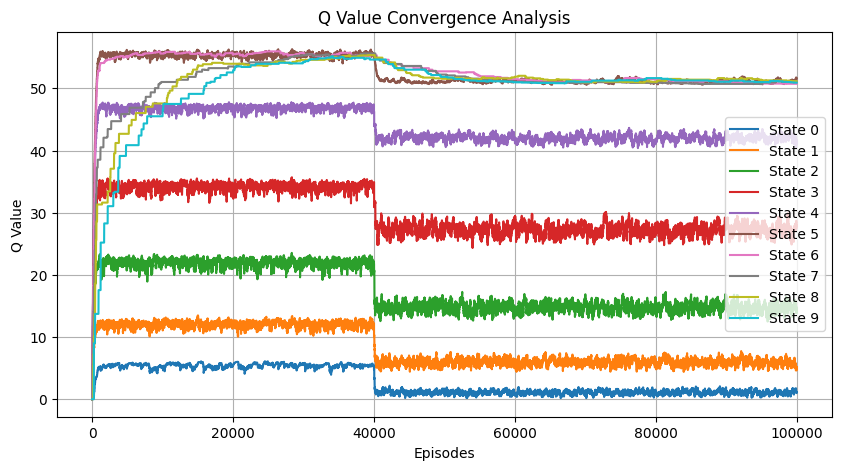

In [55]:
# Q value convergence analysis consider best Q value for each state
plt.figure(figsize=(10, 5))
# Plot the Q value for all states over episodes
for state in range(num_states):
    plt.plot(range(len(Q_history_qlearning)), [Q[state] for Q in Q_history_qlearning], label=f'State {state}')
plt.xlabel('Episodes')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

In [56]:
print("Final Q values for Q-learning:")
l = Q_qlearning_final.items()
l = sorted(l, key=lambda x: x[0])  # Sort by state
for state, actions in l:
    print(f"State {state}: {actions}")

Final Q values for Q-learning:
State 0: [50.96914813  1.1476318 ]
State 1: [51.00828533  5.127961  ]
State 2: [51.43851588 13.89002821]
State 3: [51.15106749 28.00091653]
State 4: [50.94361614 41.41679233]
State 5: [51.54164311 55.62983036]
State 6: [50.72941489 59.40775841]
State 7: [51.11248812 65.59749342]
State 8: [51.12462474 55.9224081 ]
State 9: [50.9162122  79.45022641]


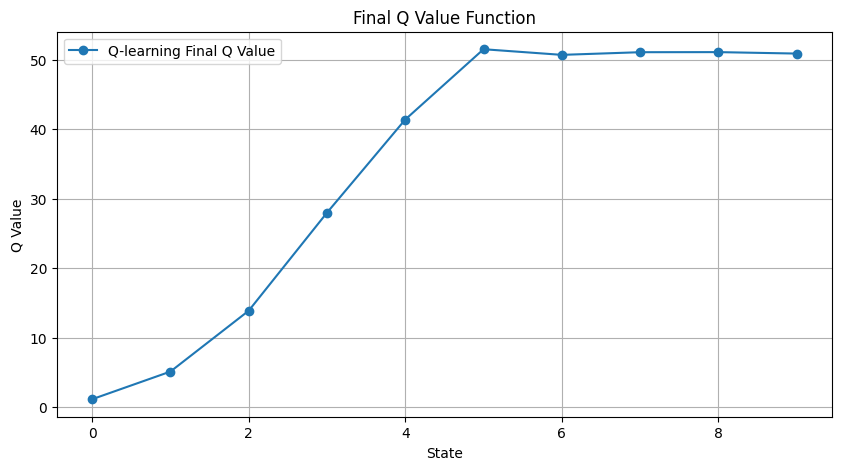

In [57]:
# plot final value function
plt.figure(figsize=(10, 5))
plt.plot(range(num_states), [np.min(Q_qlearning_final[s]) for s in range(num_states)], marker='o', label='Q-learning Final Q Value')
plt.xlabel('State')
plt.ylabel('Q Value')
plt.title('Final Q Value Function')
plt.legend()
plt.grid()
plt.show()

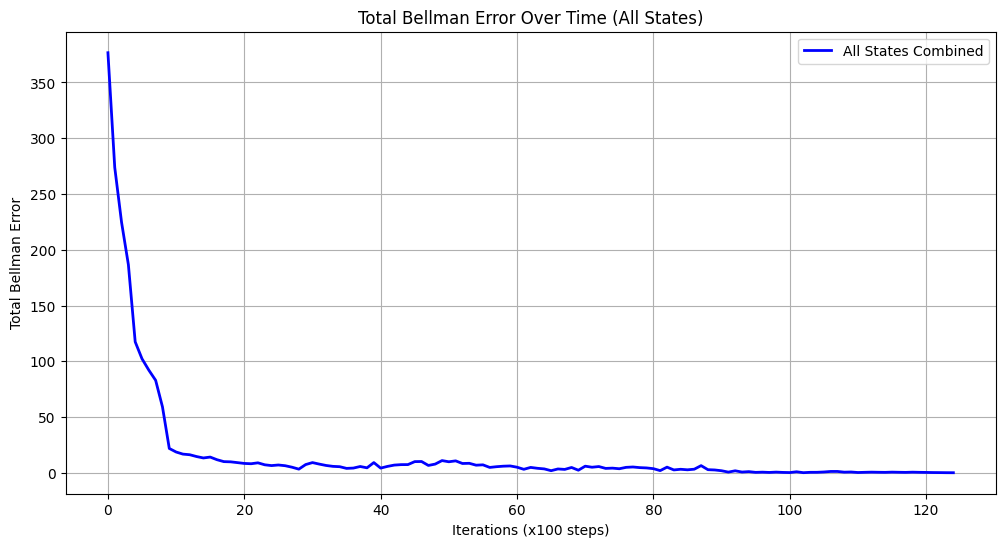

In [58]:
# Plot total Bellman error for all states (without cumulative sum over time)
plt.figure(figsize=(12, 6))

# Collect all Bellman errors with their timestamps
all_errors_by_time = {}

for state in bellman_error_qlearning:
    for action in bellman_error_qlearning[state]:
        for time_step, error in enumerate(bellman_error_qlearning[state][action]):
            if time_step not in all_errors_by_time:
                all_errors_by_time[time_step] = []
            all_errors_by_time[time_step].append(error)

# Calculate total errors at each time step (no cumulative sum)
time_steps = sorted(all_errors_by_time.keys())
total_errors_per_time = [sum(all_errors_by_time[t]) for t in time_steps]

plt.plot(time_steps, total_errors_per_time, 'b-', linewidth=2, label='All States Combined')
plt.xlabel("Iterations (x100 steps)")
plt.ylabel("Total Bellman Error")
plt.title("Total Bellman Error Over Time (All States)")
plt.legend()
plt.grid()
plt.show()